<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/transfer_learning_models_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os 

os.chdir("/content/gdrive/My Drive")

!ls  '/content/gdrive/My Drive/CS 284 Mini-Project/Code'

%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code"

 build_datasets.ipynb	   model_backup
 build_datasets_v2.ipynb   model_result
 build_datasets_v3.ipynb   models
 COVID-CT-master	   new_sars_cov
 data-git		   plots
 data-kaggle		   revised-git
 data-kaggle-uploaded	   revised-kaggle
 ECN_git.ipynb		   revised-kaggle-validation
 ECN_kaggle.ipynb	   training-from-scratch-git.ipynb
 EN_git.ipynb		  'transfer learning models (backup trash)'
 EN_kaggle.ipynb	   transfer_learning_models_git.ipynb
 Inception_github.ipynb    trial.ipynb
 master.ipynb
/content/gdrive/.shortcut-targets-by-id/1eVFVz23F6ROX0s10Oe3tT9HVzr502iW2/CS 284 Mini-Project/Code


In [ ]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

plt.ion()

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = 'revised-git'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

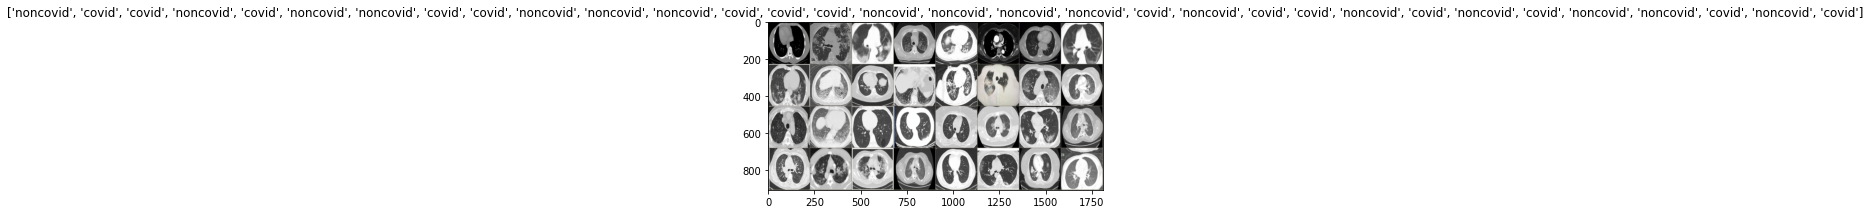

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    "Training begins..."


    train_losses = []
    test_losses = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds, name, num_epochs):
  label = ['noncovid', 'covid']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  report = classification_report(labels, preds, output_dict = True)
  df = pd.DataFrame(report).transpose()
  df.to_csv('model_result/'+name+'_epochs_'+str(num_epochs)+'_classification_report.csv', index = False)


  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['NonCovid', 'Covid'],
                      title='Confusion matrix')
  plt.savefig('plots/CM '+name+'_epochs_'+str(num_epochs)+'.png')
  plt.show()

In [ ]:
# Do validation on the test set
def test(model, dataloaders, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

<h1>Models</h1>

In [ ]:
from collections import OrderedDict


# classifier = nn.Sequential(OrderedDict([
#     ('fcl1', nn.Linear(1024,256)),
#     ('dp1', nn.Dropout(0.3)),
#     ('r1', nn.ReLU()),
#     ('fcl2', nn.Linear(256,32)),
#     ('dp2', nn.Dropout(0.3)),
#     ('r2', nn.ReLU()),
#     ('fcl3', nn.Linear(32,2)),
#     #('out', nn.LogSoftmax(dim=1)),
# ]))

In [ ]:
train_losses_all = []
test_losses_all = []

In [ ]:
def run_model(model, name, freeze = False):
  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = freeze

  #model.classifier = classifier


  if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()
    
  # NLLLoss because our output is LogSoftmax
  #criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  num_epochs = 50

  model_ft, train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=num_epochs)
  train_losses_all.append(train_losses)
  test_losses_all.append(test_losses)

  test(model, dataloaders, device, name, num_epochs)

  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.legend(frameon=False)

  plt.savefig("plots/"+name+"_epoch_"+str(num_epochs)+"_losses.png")
  torch.save(model, "model_backup/"+name+"_epoch_"+str(num_epochs)+".pth")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.6152 Acc: 0.6659
val Loss: 0.6623 Acc: 0.6186

Epoch 2/50
----------
train Loss: 0.3538 Acc: 0.8541
val Loss: 0.5816 Acc: 0.7797

Epoch 3/50
----------
train Loss: 0.1943 Acc: 0.9035
val Loss: 0.7757 Acc: 0.7034

Epoch 4/50
----------
train Loss: 0.2089 Acc: 0.9153
val Loss: 0.5158 Acc: 0.7712

Epoch 5/50
----------
train Loss: 0.0589 Acc: 0.9835
val Loss: 0.8417 Acc: 0.7627

Epoch 6/50
----------
train Loss: 0.0297 Acc: 0.9882
val Loss: 1.1659 Acc: 0.7797

Epoch 7/50
----------
train Loss: 0.0832 Acc: 0.9718
val Loss: 0.5358 Acc: 0.8220

Epoch 8/50
----------
train Loss: 0.0536 Acc: 0.9788
val Loss: 0.6586 Acc: 0.7712

Epoch 9/50
----------
train Loss: 0.0301 Acc: 0.9953
val Loss: 1.4762 Acc: 0.7119

Epoch 10/50
----------
train Loss: 0.0080 Acc: 0.9976
val Loss: 1.7893 Acc: 0.7373

Epoch 11/50
----------
train Loss: 0.2119 Acc: 0.9271
val Loss: 0.8223 Acc: 0.6949

Epoch 12/50
----------
train Loss: 0.1089 Acc: 0.9624
val Loss: 0.82

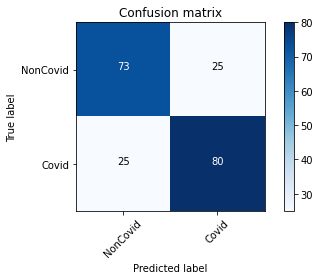

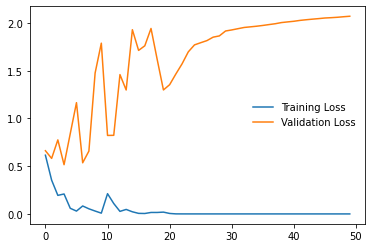

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,2)
run_model(model, name = "vgg16",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 5.2264 Acc: 0.3200
val Loss: 6.5183 Acc: 0.4407

Epoch 2/50
----------
train Loss: 0.7898 Acc: 0.9106
val Loss: 4.0987 Acc: 0.6441

Epoch 3/50
----------
train Loss: 0.1024 Acc: 0.9741
val Loss: 2.6717 Acc: 0.7203

Epoch 4/50
----------
train Loss: 0.0845 Acc: 0.9812
val Loss: 2.4733 Acc: 0.7288

Epoch 5/50
----------
train Loss: 0.1335 Acc: 0.9647
val Loss: 2.1650 Acc: 0.6695

Epoch 6/50
----------
train Loss: 0.1024 Acc: 0.9694
val Loss: 2.1346 Acc: 0.6864

Epoch 7/50
----------
train Loss: 0.0516 Acc: 0.9906
val Loss: 1.2643 Acc: 0.7288

Epoch 8/50
----------
train Loss: 0.0465 Acc: 0.9859
val Loss: 1.0103 Acc: 0.7203

Epoch 9/50
----------
train Loss: 0.0091 Acc: 0.9976
val Loss: 1.1919 Acc: 0.7542

Epoch 10/50
----------
train Loss: 0.0060 Acc: 1.0000
val Loss: 1.1558 Acc: 0.7542

Epoch 11/50
----------
train Loss: 0.0089 Acc: 0.9976
val Loss: 1.0223 Acc: 0.7627

Epoch 12/50
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.96

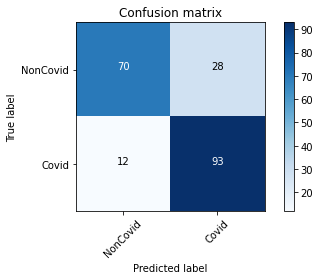

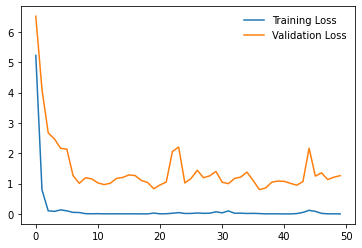

In [ ]:
model = models.resnet101(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = "resnet101",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 5.3687 Acc: 0.3035
val Loss: 4.9791 Acc: 0.5085

Epoch 2/50
----------
train Loss: 0.8591 Acc: 0.8965
val Loss: 3.1320 Acc: 0.6271

Epoch 3/50
----------
train Loss: 0.1859 Acc: 0.9600
val Loss: 2.7160 Acc: 0.6441

Epoch 4/50
----------
train Loss: 0.0664 Acc: 0.9835
val Loss: 1.6326 Acc: 0.7119

Epoch 5/50
----------
train Loss: 0.0547 Acc: 0.9835
val Loss: 1.3029 Acc: 0.7966

Epoch 6/50
----------
train Loss: 0.0437 Acc: 0.9788
val Loss: 1.2895 Acc: 0.7203

Epoch 7/50
----------
train Loss: 0.0257 Acc: 0.9976
val Loss: 1.0531 Acc: 0.7881

Epoch 8/50
----------
train Loss: 0.0149 Acc: 0.9929
val Loss: 1.2381 Acc: 0.8051

Epoch 9/50
----------
train Loss: 0.0225 Acc: 0.9953
val Loss: 1.0006 Acc: 0.7966

Epoch 10/50
----------
train Loss: 0.0146 Acc: 0.9953
val Loss: 1.0406 Acc: 0.7966

Epoch 11/50
----------
train Loss: 0.0342 Acc: 0.9859
val Loss: 1.5253 Acc: 0.7373

Epoch 12/50
----------
train Loss: 0.0119 Acc: 0.9976
val Loss: 1.31

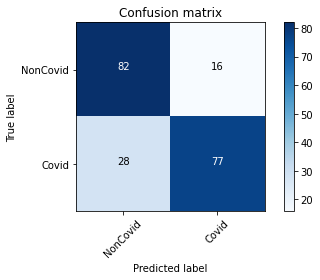

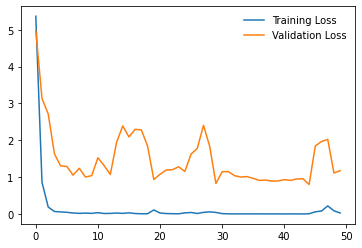

In [ ]:
model = models.resnet152(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = "resnet152",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 5.4427 Acc: 0.2965
val Loss: 7.3709 Acc: 0.1441

Epoch 2/50
----------
train Loss: 0.8023 Acc: 0.8965
val Loss: 5.0791 Acc: 0.3729

Epoch 3/50
----------
train Loss: 0.1719 Acc: 0.9647
val Loss: 2.9338 Acc: 0.7203

Epoch 4/50
----------
train Loss: 0.0534 Acc: 0.9812
val Loss: 1.6108 Acc: 0.7542

Epoch 5/50
----------
train Loss: 0.0248 Acc: 0.9929
val Loss: 2.1572 Acc: 0.6441

Epoch 6/50
----------
train Loss: 0.0250 Acc: 0.9929
val Loss: 1.6800 Acc: 0.7119

Epoch 7/50
----------
train Loss: 0.0211 Acc: 0.9953
val Loss: 1.3125 Acc: 0.7712

Epoch 8/50
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 1.1510 Acc: 0.8136

Epoch 9/50
----------
train Loss: 0.0118 Acc: 0.9953
val Loss: 0.9470 Acc: 0.8220

Epoch 10/50
----------
train Loss: 0.0189 Acc: 0.9929
val Loss: 1.1700 Acc: 0.8136

Epoch 11/50
----------
train Loss: 0.0071 Acc: 1.0000
val Loss: 1.3934 Acc: 0.8305

Epoch 12/50
----------
train Loss: 0.0213 Acc: 0.9976
val Loss: 1.44

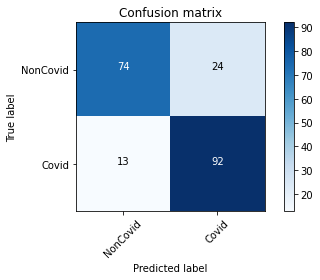

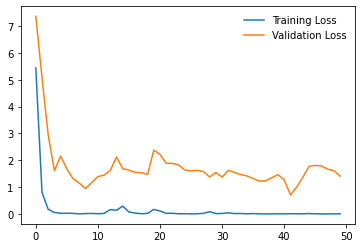

In [ ]:
model = models.resnet50(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model,  name = "resnet50", freeze = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 6.6567 Acc: 0.1600
val Loss: 7.6888 Acc: 0.1186

Epoch 2/50
----------
train Loss: 2.3986 Acc: 0.7553
val Loss: 6.7893 Acc: 0.2119

Epoch 3/50
----------
train Loss: 0.5829 Acc: 0.9459
val Loss: 3.8519 Acc: 0.5254

Epoch 4/50
----------
train Loss: 0.1355 Acc: 0.9788
val Loss: 2.7094 Acc: 0.7458

Epoch 5/50
----------
train Loss: 0.1411 Acc: 0.9835
val Loss: 2.0144 Acc: 0.7712

Epoch 6/50
----------
train Loss: 0.0438 Acc: 0.9882
val Loss: 2.3078 Acc: 0.7288

Epoch 7/50
----------
train Loss: 0.0246 Acc: 0.9976
val Loss: 2.1310 Acc: 0.7627

Epoch 8/50
----------
train Loss: 0.0593 Acc: 0.9906
val Loss: 1.8448 Acc: 0.7881

Epoch 9/50
----------
train Loss: 0.0176 Acc: 0.9976
val Loss: 1.9311 Acc: 0.7797

Epoch 10/50
----------
train Loss: 0.0081 Acc: 1.0000
val Loss: 2.0843 Acc: 0.7797

Epoch 11/50
----------
train Loss: 0.0087 Acc: 1.0000
val Loss: 2.0908 Acc: 0.7966

Epoch 12/50
----------
train Loss: 0.0070 Acc: 1.0000
val Loss: 1.90

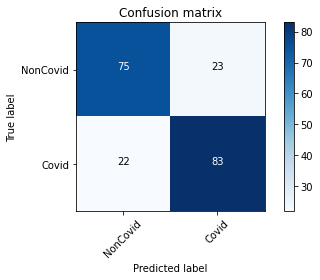

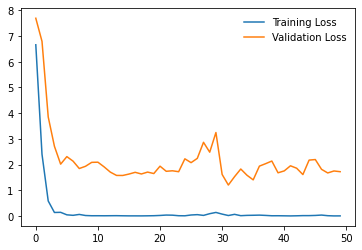

In [ ]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model,  name = "resnet18", freeze = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.5317 Acc: 0.7271
val Loss: 0.6207 Acc: 0.6610

Epoch 2/50
----------
train Loss: 0.2402 Acc: 0.9224
val Loss: 0.5724 Acc: 0.7203

Epoch 3/50
----------
train Loss: 0.1113 Acc: 0.9835
val Loss: 0.5370 Acc: 0.7627

Epoch 4/50
----------
train Loss: 0.0465 Acc: 0.9976
val Loss: 0.6220 Acc: 0.7712

Epoch 5/50
----------
train Loss: 0.0286 Acc: 1.0000
val Loss: 0.6969 Acc: 0.7797

Epoch 6/50
----------
train Loss: 0.0217 Acc: 0.9976
val Loss: 0.7196 Acc: 0.7712

Epoch 7/50
----------
train Loss: 0.0119 Acc: 1.0000
val Loss: 0.7899 Acc: 0.7373

Epoch 8/50
----------
train Loss: 0.0264 Acc: 0.9953
val Loss: 0.8027 Acc: 0.7542

Epoch 9/50
----------
train Loss: 0.0588 Acc: 0.9835
val Loss: 0.7907 Acc: 0.7712

Epoch 10/50
----------
train Loss: 0.0357 Acc: 0.9929
val Loss: 0.8162 Acc: 0.7542

Epoch 11/50
----------
train Loss: 0.0270 Acc: 0.9953
val Loss: 0.8402 Acc: 0.7627

Epoch 12/50
----------
train Loss: 0.0520 Acc: 0.9812
val Loss: 0.88

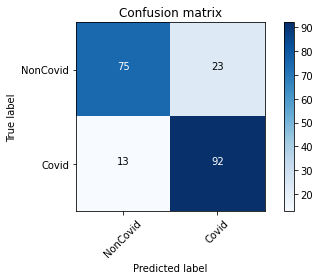

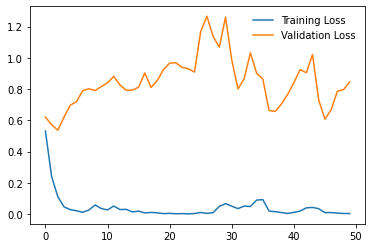

In [ ]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model,  name = "densenet121", freeze = True)

<h1>Plot All Losses</h1>

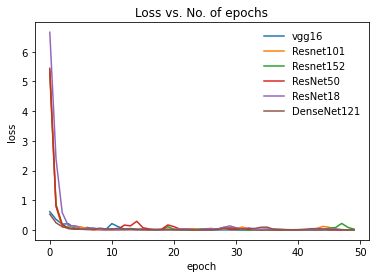

In [ ]:
def plot_all_losses(losses, t):
    plt.figure()
    models = ['vgg16', 'Resnet101','Resnet152', 'ResNet50', 'ResNet18', 'DenseNet121']

    for i, val in enumerate(losses):
        plt.plot(val, label=models[i])
        plt.legend(frameon=False)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')   
    plt.savefig("plots/"+t+"_losses_resnet.png")
    plt.show()
        
plot_all_losses(train_losses_all, t="training")

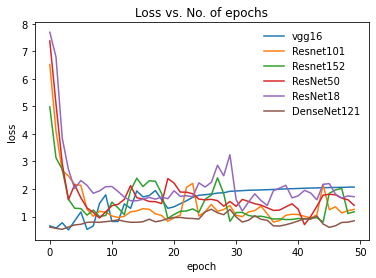

In [ ]:
plot_all_losses(test_losses_all, t="testing")